In [1]:
#Random forest: https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

In [2]:
!pip install imblearn==0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 KB 11.1 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [4]:
#the file that contains all issues and all fields
allBounty = pd.read_csv("dataset/gitcoin_dataset_5.csv")

#the file that contains fields from 'activities' array e.g. activity_type, duration_create_to_done
activity_coll = pd.read_csv("dataset/activities_collection_3.csv")

#the file that contains '# of times bounty increased' from 'activities' array
bounty_changed = pd.read_csv("dataset/changedBounty2.csv")

In [5]:
#Cleansing data

activity_coll.drop('duration_worker_applied_to_worker_approved',axis='columns', inplace=True)

#fill-in 'numerical values' with their median
allBounty['value_in_eth'].fillna(float(allBounty['value_in_eth'].median()), inplace = True)
allBounty['value_in_usdt_now'].fillna(float(allBounty['value_in_usdt_now'].median()), inplace = True)
allBounty['value_in_usdt'].fillna(float(allBounty['value_in_usdt'].median()), inplace = True)
allBounty['token_value_in_usdt'].fillna(float(allBounty['token_value_in_usdt'].median()), inplace = True)

#fill-in 'categorical values' with "NA" (except for github_issue_number)
allBounty['title'].fillna("NA", inplace = True)
allBounty['funder_last_messaged_on'].fillna("NA", inplace = True)
allBounty['is_reserved'].fillna("NA", inplace = True)
allBounty['canceled_bounty_reason'].fillna("NA", inplace = True)
allBounty['reserved_for_user_handle'].fillna("NA", inplace = True)
allBounty['attached_job_description'].fillna("NA", inplace = True)
allBounty['canceled_on'].fillna("NA", inplace = True)
allBounty['funding_organisation'].fillna("NA", inplace = True)
allBounty['featuring_date'].fillna("NA", inplace = True)
allBounty['fulfillment_accepted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_submitted_on'].fillna("NA", inplace = True)
allBounty['fulfillment_started_on'].fillna("NA", inplace = True)
allBounty['keywords'].fillna("NA", inplace = True)
allBounty['bounty_owner_name'].fillna("NA", inplace = True)
allBounty['github_issue_state'].fillna("NA", inplace = True)
allBounty['bounty_owner_github_username'].fillna("NA", inplace = True)
allBounty['bounty_owner_email'].fillna("NA", inplace = True)
allBounty['github_issue_number'].fillna(0, inplace = True)
allBounty['github_repo_name'].fillna("NA", inplace = True)
allBounty['org_name'].fillna("NA", inplace = True)
allBounty['github_org_name'].fillna("NA", inplace = True)

allBounty.loc[allBounty['bounty_type'] == "0", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Andere", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "Funkcja", 'bounty_type'] = "Other"
allBounty.loc[allBounty['bounty_type'] == "æ¹å", 'bounty_type'] = "Other"
allBounty['bounty_type'].fillna("NA", inplace = True)

allBounty.loc[allBounty['experience_level'] == "0", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Mittlere", 'experience_level'] = "Intermediate"
allBounty.loc[allBounty['experience_level'] == "åå¿è", 'experience_level'] = "Other"
allBounty.loc[allBounty['experience_level'] == "Pośredni", 'experience_level'] = "Intermediate"
allBounty['experience_level'].fillna("NA", inplace = True)

allBounty.loc[allBounty['project_length'] == "0", 'project_length'] = "Unknown"
allBounty.loc[allBounty['project_length'] == "Tage", 'project_length'] = "Days"
allBounty.loc[allBounty['project_length'] == "Miesięcy", 'project_length'] = "Months"
allBounty['project_length'].fillna("NA", inplace = True)

In [6]:
#merge two dataframe together
outer_merged = pd.merge(allBounty, activity_coll, how="outer", on=["pk"])
outer_merged = pd.merge(outer_merged, bounty_changed, how="outer", on=["pk"])

outer_merged['increased_bounty_times'].fillna(0, inplace = True)
outer_merged['changed_bounty_value'].fillna(0, inplace = True)

outer_merged['firstAct_activity_type'].fillna("NA", inplace = True)
outer_merged['lastAct_activity_type'].fillna("NA", inplace = True)

outer_merged['duration_create_to_done'].fillna(0, inplace = True)
outer_merged['duration_create_to_firstAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_killed'].fillna(0, inplace = True)
outer_merged['duration_create_to_lastAct'].fillna(0, inplace = True)
outer_merged['duration_create_to_new_bounty'].fillna(0, inplace = True)
outer_merged['duration_create_to_start'].fillna(0, inplace = True)
outer_merged['duration_create_to_stop'].fillna(0, inplace = True)
outer_merged['duration_create_to_submitted'].fillna(0, inplace = True)
outer_merged['duration_create_to_worker_applied'].fillna(0, inplace = True)
outer_merged['number_of_user_in_activities'].fillna(0, inplace = True)

In [7]:
#change cathegory to number

#experience_level
outer_merged['experience_level_code'] = outer_merged['experience_level']
find_replace = {"experience_level_code" : {"NA": 0, "Other": 0, "Beginner": 1, "Intermediate": 2, "Advanced": 3}}
outer_merged.replace(find_replace, inplace=True)

#project_length
outer_merged['project_length_code'] = outer_merged['project_length']
find_replace = {"project_length_code" : {"NA": 0, "Unknown": 0, "Hours": 1, "Days": 24, "Weeks": 168, "Months": 720}} #in hours
outer_merged.replace(find_replace, inplace=True)

In [8]:
#normalization
#https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler() 
column_names_to_normalize = ['changed_bounty_value','github_comments','increased_bounty_times','description_length','duration_create_to_expire','number_of_activities','number_of_fulfillments','number_of_interests','token_value_in_usdt','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now','duration_create_to_done','duration_create_to_firstAct','duration_create_to_killed','duration_create_to_lastAct','duration_create_to_new_bounty','duration_create_to_start','duration_create_to_stop','duration_create_to_submitted','duration_create_to_worker_applied','number_of_user_in_activities']
x = outer_merged[column_names_to_normalize].values
x_scaled = min_max_scaler.fit_transform(x)
outer_merged_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = outer_merged.index)
outer_merged[column_names_to_normalize] = outer_merged_temp

In [9]:
pd.set_option('display.max_columns', None)
outer_merged_temp.describe()
outer_merged_temp.shape
outer_merged.describe()
outer_merged.shape

,changed_bounty_value,github_comments,increased_bounty_times,description_length,duration_create_to_expire,number_of_activities,number_of_fulfillments,number_of_interests,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities
count,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.000841,0.084412,0.004005,0.051541,0.102374,0.031279,0.010140,0.014849,0.007655,0.000589,5.869119e-04,0.000609,0.000620,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320
std,0.018127,0.117538,0.025336,0.056217,0.274589,0.049440,0.039168,0.040416,0.024649,0.020894,1.702679e-02,0.020923,0.020905,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000045,0.010638,0.000000,0.015718,0.000242,0.012500,0.000000,0.006024,0.000028,0.000010,1.361610e-08,0.000012,0.000010,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765
50%,0.000045,0.042553,0.000000,0.033951,0.000259,0.020000,0.006410,0.006024,0.003430,0.000026,1.270836e-07,0.000029,0.000026,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647
75%,0.000045,0.117021,0.000000,0.068522,0.003145,0.032500,0.006410,0.012048,0.008937,0.000071,1.089288e-05,0.000079,0.000079,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 23)

,description_length,duration_create_to_expire,github_comments,github_issue_number,is_paid,is_success,number_of_activities,number_of_fulfillments,number_of_interests,pk,standard_bounties_id,token_value_in_usdt,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,value_true,duration_create_to_done,duration_create_to_firstAct,duration_create_to_killed,duration_create_to_lastAct,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_submitted,duration_create_to_worker_applied,number_of_user_in_activities,increased_bounty_times,changed_bounty_value,experience_level_code,project_length_code
count,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.051541,0.102374,0.084412,2.752041e+03,0.580716,0.580716,0.031279,0.010140,0.014849,14940.176483,1.689004e+07,0.007655,0.000589,5.869119e-04,0.000609,0.000620,1.759311e+04,0.032849,0.003017,0.023449,0.219392,0.362647,0.006785,0.016800,0.078956,0.009370,0.025320,0.004005,0.000841,1.578098,20.155541
std,0.056217,0.274589,0.117538,1.214674e+05,0.493496,0.493496,0.049440,0.039168,0.040416,6748.159187,3.747219e+07,0.024649,0.020894,1.702679e-02,0.020923,0.020905,7.617667e+05,0.075719,0.029698,0.086083,0.226041,0.046084,0.040718,0.061074,0.187339,0.051110,0.045570,0.025336,0.018127,0.903123,62.679123
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.015718,0.000242,0.010638,9.000000e+00,0.000000,0.000000,0.012500,0.000000,0.006024,10345.750000,1.415750e+03,0.000028,0.000010,1.361610e-08,0.000012,0.000010,2.500000e-01,0.000000,0.001304,0.000000,0.023263,0.355253,0.000000,0.000000,0.000000,0.000831,0.011765,0.000000,0.000045,1.000000,1.000000
50%,0.033951,0.000259,0.042553,7.200000e+01,1.000000,1.000000,0.020000,0.006410,0.006024,14574.500000,2.931500e+03,0.003430,0.000026,1.270836e-07,0.000029,0.000026,3.000000e+00,0.003132,0.001306,0.000000,0.118539,0.355684,0.000000,0.000000,0.005193,0.000835,0.017647,0.000000,0.000045,2.000000,1.000000
75%,0.068522,0.003145,0.117021,5.212500e+02,1.000000,1.000000,0.032500,0.006410,0.012048,21592.000000,4.158250e+03,0.008937,0.000071,1.089288e-05,0.000079,0.000079,1.500000e+02,0.031154,0.001310,0.000000,0.393087,0.356496,0.000562,0.007055,0.030450,0.001513,0.023529,0.000000,0.000045,2.000000,24.000000
max,1.000000,1.000000,1.000000,8.223423e+06,1.000000,1.000000,1.000000,1.000000,1.000000,24558.000000,1.000246e+08,1.000000,1.000000,1.000000e+00,1.000000,1.000000,5.000000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,720.000000


(4584, 87)

In [10]:
#all features used in Table 2 Feature Description
columns_temp = ['pk','is_success','duration_create_to_expire','value_in_eth','value_in_token','value_in_usdt','value_in_usdt_now',
                'project_length_code','experience_level_code','project_type',
                'github_comments','number_of_activities','number_of_fulfillments','number_of_interests',
                'description_length','duration_create_to_done','duration_create_to_firstAct','duration_create_to_lastAct',
                'duration_create_to_submitted','duration_create_to_killed','duration_create_to_new_bounty',
                'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                'number_of_user_in_activities','changed_bounty_value','increased_bounty_times','bounty_type','token_name',
                'firstAct_activity_type','lastAct_activity_type','token_value_in_usdt']

outer_merged_temp = outer_merged[columns_temp]
outer_merged = outer_merged_temp

In [11]:
outer_merged.describe()
outer_merged.shape

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,14940.176483,0.580716,0.102374,0.000589,5.869119e-04,0.000609,0.000620,20.155541,1.578098,0.084412,0.031279,0.010140,0.014849,0.051541,0.032849,0.003017,0.219392,0.078956,0.023449,0.362647,0.006785,0.016800,0.009370,0.025320,0.000841,0.004005,0.007655
std,6748.159187,0.493496,0.274589,0.020894,1.702679e-02,0.020923,0.020905,62.679123,0.903123,0.117538,0.049440,0.039168,0.040416,0.056217,0.075719,0.029698,0.226041,0.187339,0.086083,0.046084,0.040718,0.061074,0.051110,0.045570,0.018127,0.025336,0.024649
min,11.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10345.750000,0.000000,0.000242,0.000010,1.361610e-08,0.000012,0.000010,1.000000,1.000000,0.010638,0.012500,0.000000,0.006024,0.015718,0.000000,0.001304,0.023263,0.000000,0.000000,0.355253,0.000000,0.000000,0.000831,0.011765,0.000045,0.000000,0.000028
50%,14574.500000,1.000000,0.000259,0.000026,1.270836e-07,0.000029,0.000026,1.000000,2.000000,0.042553,0.020000,0.006410,0.006024,0.033951,0.003132,0.001306,0.118539,0.005193,0.000000,0.355684,0.000000,0.000000,0.000835,0.017647,0.000045,0.000000,0.003430
75%,21592.000000,1.000000,0.003145,0.000071,1.089288e-05,0.000079,0.000079,24.000000,2.000000,0.117021,0.032500,0.006410,0.012048,0.068522,0.031154,0.001310,0.393087,0.030450,0.000000,0.356496,0.000562,0.007055,0.001513,0.023529,0.000045,0.000000,0.008937
max,24558.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,720.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(4584, 32)

In [12]:
# Making categorical variables into numeric representation
feature_to_trans_set2 = ['bounty_type','token_name','project_type']

new_raw_data_set2 = pd.get_dummies(outer_merged, columns = feature_to_trans_set2)

In [13]:
#bootstrap sampling
#https://allendowney.github.io/ElementsOfDataScience/12_bootstrap.html
from random import sample

bootstrapped_set2 = new_raw_data_set2.sample(n=4584, replace=True)
bootstrapped_set2.shape

repeats = bootstrapped_set2['pk'].value_counts()
repeats.head()

new_raw_data_set2.describe()
bootstrapped_set2.describe()

(4584, 125)

18985    7
2836     6
24352    6
21459    5
16817    5
Name: pk, dtype: int64

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,14940.176483,0.580716,0.102374,0.000589,5.869119e-04,0.000609,0.000620,20.155541,1.578098,0.084412,0.031279,0.010140,0.014849,0.051541,0.032849,0.003017,0.219392,0.078956,0.023449,0.362647,0.006785,0.016800,0.009370,0.025320,0.000841,0.004005,0.007655,0.072644,0.004363,0.010035,0.048866,0.403796,0.148124,0.221422,0.075480,0.015271,0.000218,0.000654,0.000873,0.000218,0

,pk,is_success,duration_create_to_expire,value_in_eth,value_in_token,value_in_usdt,value_in_usdt_now,project_length_code,experience_level_code,github_comments,number_of_activities,number_of_fulfillments,number_of_interests,description_length,duration_create_to_done,duration_create_to_firstAct,duration_create_to_lastAct,duration_create_to_submitted,duration_create_to_killed,duration_create_to_new_bounty,duration_create_to_start,duration_create_to_stop,duration_create_to_worker_applied,number_of_user_in_activities,changed_bounty_value,increased_bounty_times,token_value_in_usdt,bounty_type_Bug,bounty_type_Code Review,bounty_type_Design,bounty_type_Documentation,bounty_type_Feature,bounty_type_Improvement,bounty_type_NA,bounty_type_Other,bounty_type_Security,token_name_0xBTC,token_name_AEUR,token_name_AION,token_name_ALEX,token_name_ANT,token_name_AVO,token_name_BAND,token_name_BLZ,token_name_BNB,token_name_BNT,token_name_BORIS,token_name_BRLN,token_name_BTC,token_name_CBTX,token_name_CHI,token_name_CLN,token_name_COIN,token_name_DAI,token_name_DAT,token_name_DATA,token_name_DIA,token_name_DOT,token_name_ENG,token_name_ETC,token_name_ETH,token_name_FIL,token_name_G$,token_name_GLM,token_name_GLX,token_name_GNO,token_name_HARBTY,token_name_HERC,token_name_JAMM,token_name_KEEP,token_name_KIWI,token_name_KNC,token_name_KSM,token_name_LEAP,token_name_LIKE,token_name_LINK,token_name_LPT,token_name_LRC,token_name_LUNA,token_name_MANA,token_name_MATIC,token_name_MESG,token_name_MYB,token_name_NKN,token_name_NTV,token_name_OCEAN,token_name_ONE,token_name_OTHER,token_name_PAN,token_name_PBLC,token_name_POLY,token_name_PROCN,token_name_RDN,token_name_REN,token_name_RHOC,token_name_RLC,token_name_RLY,token_name_SAI,token_name_SC,token_name_SGR,token_name_SHIP,token_name_SNT,token_name_SNX,token_name_ST,token_name_STORJ,token_name_SWAGG,token_name_SYSX,token_name_TRB,token_name_TUSD,token_name_USD,token_name_USDC,token_name_USDT,token_name_WBTC,token_name_WYV,token_name_XRT,token_name_ZIL,token_name_ZRX,token_name_aDAI,token_name_cUSD,token_name_wNXM,project_type_contest,project_type_cooperative,project_type_traditional
count,4584.000000,4584.000000,4584.000000,4584.000000,4.584000e+03,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,15003.569590,0.583988,0.100127,0.000582,3.831392e-04,0.000602,0.000609,20.812173,1.585733,0.086401,0.031409,0.010677,0.015115,0.052795,0.034650,0.002273,0.224018,0.081445,0.021682,0.363196,0.007047,0.016690,0.009804,0.025896,0.001198,0.003989,0.007864,0.074607,0.003709,0.010035,0.042103,0.415576,0.144197,0.215532,0.075698,0.018543,0.0,0.001091,0.001963,0.000218,0.002400,0.000873,0.000218,0.002182,0.0,0.000873,0.00087

RandomForestClassifier(criterion='entropy', max_depth=25)

0.7340116279069767

array([[305, 272],
       [ 94, 705]])

<Figure size 1600x700 with 0 Axes>

<AxesSubplot: >

Text(0.5, 47.7222222222222, 'Predicted label')

Text(170.72222222222223, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

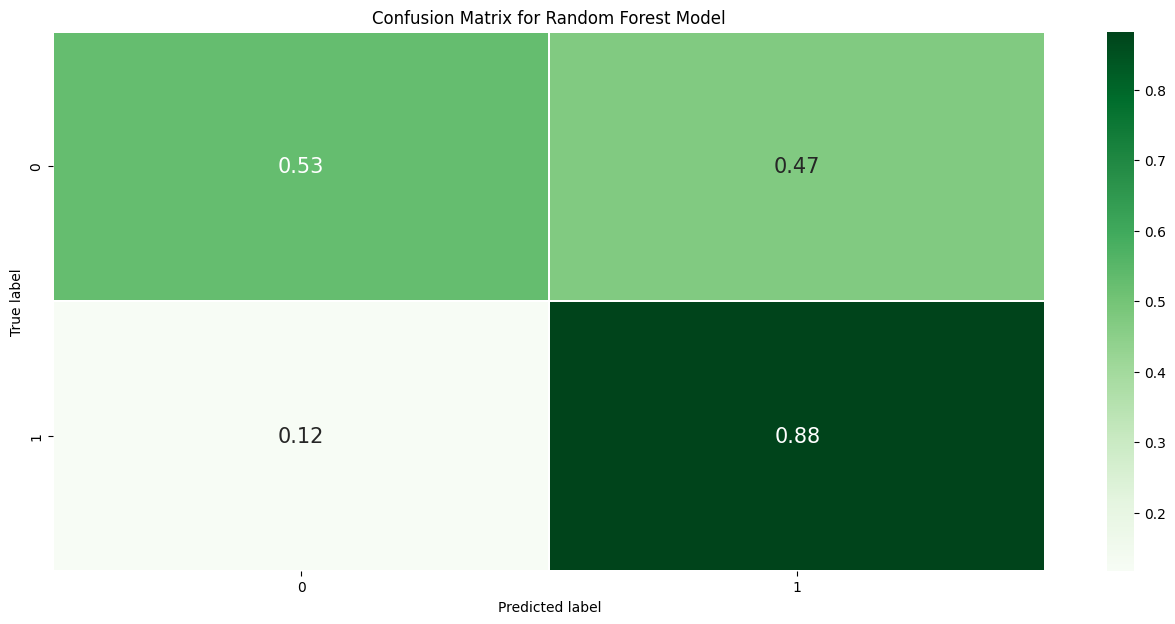

              precision    recall  f1-score   support

           0       0.76      0.53      0.62       577
           1       0.72      0.88      0.79       799

    accuracy                           0.73      1376
   macro avg       0.74      0.71      0.71      1376
weighted avg       0.74      0.73      0.72      1376



array([9.15743285e-02, 7.33498921e-02, 4.68206071e-02, 9.62935539e-02,
       8.41757281e-02, 3.22679421e-02, 3.10089335e-02, 1.26486834e-01,
       1.23930211e-01, 1.37690868e-01, 8.32757550e-03, 1.47156236e-03,
       2.12500058e-03, 7.25220461e-03, 1.38577438e-02, 9.35161029e-03,
       9.24435567e-03, 8.77644105e-03, 3.19697535e-03, 2.63441022e-04,
       3.00825398e-04, 2.74849072e-04, 0.00000000e+00, 9.68900344e-04,
       2.95817095e-04, 1.66782619e-04, 1.03799073e-03, 1.12728422e-04,
       0.00000000e+00, 3.51761927e-04, 7.41632679e-05, 1.96221825e-04,
       3.93859110e-04, 1.08123043e-03, 3.76144890e-04, 6.43598757e-05,
       9.19747096e-03, 2.74161284e-04, 5.14002582e-05, 1.11184940e-03,
       4.40895669e-03, 3.87730220e-04, 3.10014749e-03, 7.45543026e-03,
       2.53139106e-05, 3.14117261e-05, 1.32121126e-04, 6.62448064e-05,
       1.01712680e-04, 5.07733841e-04, 8.59176626e-04, 0.00000000e+00,
       1.67723662e-04, 2.33333162e-04, 2.81211493e-04, 7.41831844e-04,
      

The feature importance for duration_create_to_expire is : 0.09157432851572096
The feature importance for value_in_eth is : 0.07334989205177067
The feature importance for value_in_token is : 0.04682060709257131
The feature importance for value_in_usdt is : 0.09629355393266266
The feature importance for value_in_usdt_now is : 0.08417572806991336
The feature importance for project_length_code is : 0.03226794211142402
The feature importance for experience_level_code is : 0.03100893347540402
The feature importance for description_length is : 0.1264868335844949
The feature importance for duration_create_to_new_bounty is : 0.12393021125767138
The feature importance for token_value_in_usdt is : 0.13769086794087626
The feature importance for bounty_type_Bug is : 0.008327575500538965
The feature importance for bounty_type_Code Review is : 0.001471562356298492
The feature importance for bounty_type_Design is : 0.0021250005793879336
The feature importance for bounty_type_Documentation is : 0.00725

,Feature,Feature Importance
9,token_value_in_usdt,0.137691
7,description_length,0.126487
8,duration_create_to_new_bounty,0.123930
3,value_in_usdt,0.096294
0,duration_create_to_expire,0.091574
4,value_in_usdt_now,0.084176
1,value_in_eth,0.073350
2,value_in_token,0.046821
5,project_length_code,0.032268
6,experience_level_code,0.031009


In [14]:
#Setting 2 - without boothstrap

# Split dataset into features and target
y = new_raw_data_set2['is_success']
X = new_raw_data_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                      'firstAct_activity_type','lastAct_activity_type'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=25)
forest.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

#-----------------------------------------------------------------------------------------------------------
forest.feature_importances_

#-------------------------------------------------------------------------------------------------------------
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(new_raw_data_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                        'firstAct_activity_type','lastAct_activity_type'], axis = 1)):
    
    print('The feature importance for {} is : {}'.format(column, forest.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(forest.feature_importances_[i])
    
# Creating a Dataframe
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance', ascending = False).head(10)

RandomForestClassifier(criterion='entropy', max_depth=25)

0.8481104651162791

array([[411, 161],
       [ 48, 756]])

<Figure size 1600x700 with 0 Axes>

<AxesSubplot: >

Text(0.5, 47.7222222222222, 'Predicted label')

Text(170.72222222222223, 0.5, 'True label')

Text(0.5, 1.0, 'Confusion Matrix for Random Forest Model')

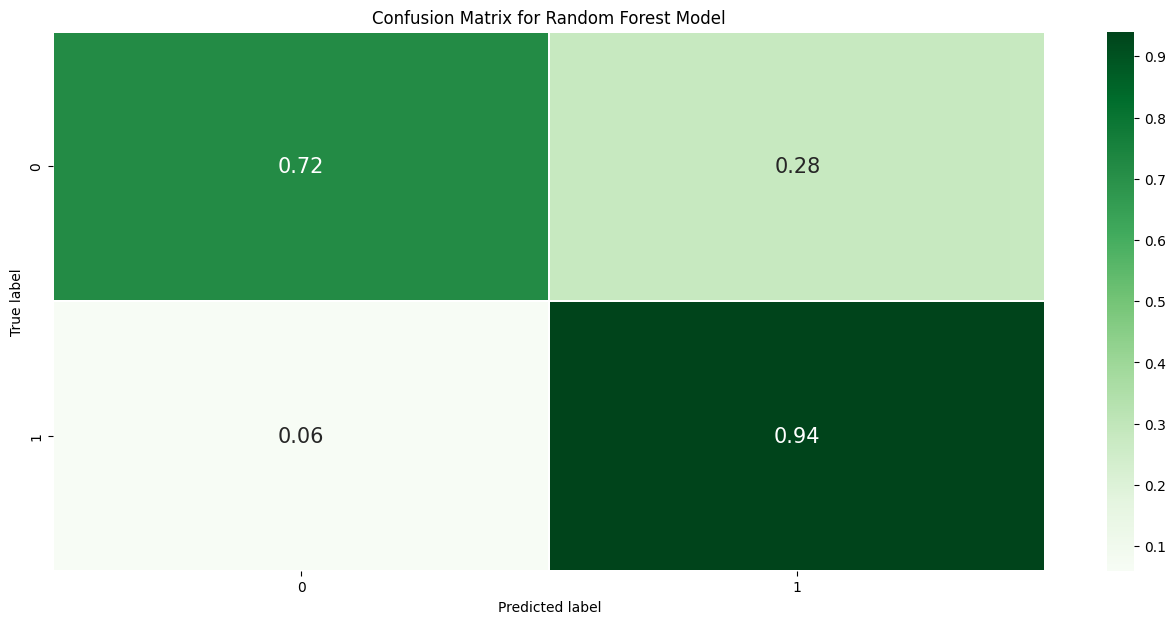

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       572
           1       0.82      0.94      0.88       804

    accuracy                           0.85      1376
   macro avg       0.86      0.83      0.84      1376
weighted avg       0.85      0.85      0.84      1376



array([9.06451854e-02, 7.24489032e-02, 4.44795443e-02, 9.39627071e-02,
       8.42695947e-02, 3.30614554e-02, 3.25842884e-02, 1.27399080e-01,
       1.18946722e-01, 1.43015297e-01, 9.78664231e-03, 1.09278216e-03,
       2.07492942e-03, 5.86536421e-03, 1.22863143e-02, 9.42668728e-03,
       9.39040603e-03, 7.49659842e-03, 3.77164055e-03, 0.00000000e+00,
       8.10467365e-04, 4.15662337e-04, 2.34930288e-04, 4.41445810e-04,
       3.87272978e-04, 2.60198684e-04, 9.79189586e-04, 0.00000000e+00,
       8.71191195e-05, 3.54075504e-04, 0.00000000e+00, 1.57483631e-04,
       4.23208035e-04, 8.95279163e-04, 7.59534136e-04, 0.00000000e+00,
       9.07254331e-03, 9.49382290e-05, 9.93794621e-05, 1.05901333e-03,
       4.03891921e-03, 4.15816247e-04, 3.28038656e-03, 8.51041531e-03,
       2.24766281e-05, 4.44005592e-05, 8.67537003e-05, 0.00000000e+00,
       7.73691244e-05, 2.32615536e-04, 7.80619460e-04, 0.00000000e+00,
       2.42358856e-04, 0.00000000e+00, 1.67456014e-04, 2.39734221e-04,
      

The feature importance for duration_create_to_expire is : 0.09064518538768793
The feature importance for value_in_eth is : 0.07244890321070349
The feature importance for value_in_token is : 0.044479544265175995
The feature importance for value_in_usdt is : 0.09396270714400991
The feature importance for value_in_usdt_now is : 0.08426959470987588
The feature importance for project_length_code is : 0.03306145540756715
The feature importance for experience_level_code is : 0.03258428835433384
The feature importance for description_length is : 0.1273990800461545
The feature importance for duration_create_to_new_bounty is : 0.11894672237755012
The feature importance for token_value_in_usdt is : 0.14301529712049005
The feature importance for bounty_type_Bug is : 0.00978664230552995
The feature importance for bounty_type_Code Review is : 0.0010927821590485196
The feature importance for bounty_type_Design is : 0.002074929416239342
The feature importance for bounty_type_Documentation is : 0.00586

,Feature,Feature Importance
9,token_value_in_usdt,0.143015
7,description_length,0.127399
8,duration_create_to_new_bounty,0.118947
3,value_in_usdt,0.093963
0,duration_create_to_expire,0.090645
4,value_in_usdt_now,0.084270
1,value_in_eth,0.072449
2,value_in_token,0.044480
5,project_length_code,0.033061
6,experience_level_code,0.032584


In [15]:
#Setting 2 - with bootstrap

# Split dataset into features and target
y = bootstrapped_set2['is_success']
X = bootstrapped_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                      'firstAct_activity_type','lastAct_activity_type'], axis = 1).values

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

# Instantiate and fit the RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', max_depth=25)
forest.fit(X_train, y_train)

# Make predictions for the test set
y_pred_test = forest.predict(X_test)

# View accuracy score
accuracy_score(y_test, y_pred_test)

# View confusion matrix for test data and predictions
confusion_matrix(y_test, y_pred_test)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred_test)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

#-----------------------------------------------------------------------------------------------------------
forest.feature_importances_

#-------------------------------------------------------------------------------------------------------------
# Running Feature Importance

fi_col = []
fi = []

for i,column in enumerate(bootstrapped_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                        'firstAct_activity_type','lastAct_activity_type'], axis = 1)):
    
    print('The feature importance for {} is : {}'.format(column, forest.feature_importances_[i]))
    
    fi_col.append(column)
    fi.append(forest.feature_importances_[i])
    
# Creating a Dataframe
fi_df = zip(fi_col, fi)
fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
fi_df.sort_values('Feature Importance', ascending = False).head(10)

In [16]:
#Point Biserial

In [17]:
#https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1

from scipy.stats import pointbiserialr

for x in bootstrapped_set2.drop(['is_success','pk','github_comments','number_of_activities','number_of_fulfillments',
                       'number_of_interests','duration_create_to_done','duration_create_to_firstAct',
                       'duration_create_to_lastAct','duration_create_to_submitted','duration_create_to_killed',
                        'duration_create_to_start','duration_create_to_stop','duration_create_to_worker_applied',
                        'number_of_user_in_activities','changed_bounty_value','increased_bounty_times',
                        'firstAct_activity_type','lastAct_activity_type'], axis = 1):
    print (x)
    pointbiserialr(bootstrapped_set2['is_success'], bootstrapped_set2[x])

duration_create_to_expire


PointbiserialrResult(correlation=-0.12853140059282303, pvalue=2.412249139026707e-18)

value_in_eth


PointbiserialrResult(correlation=-0.025063655573792674, pvalue=0.08974495041224863)

value_in_token


PointbiserialrResult(correlation=-0.0250068443529441, pvalue=0.09047498767610795)

value_in_usdt


PointbiserialrResult(correlation=-0.02814441732737289, pvalue=0.05673038626360596)

value_in_usdt_now


PointbiserialrResult(correlation=-0.024483770569122047, pvalue=0.09742327581500056)

project_length_code


PointbiserialrResult(correlation=-0.04509633499167205, pvalue=0.002258276576744314)

experience_level_code


PointbiserialrResult(correlation=-0.09081588927278257, pvalue=7.28522195185859e-10)

description_length


PointbiserialrResult(correlation=-0.025706790939069673, pvalue=0.08180680205865588)

duration_create_to_new_bounty


PointbiserialrResult(correlation=0.004512568146955236, pvalue=0.760028961218082)

token_value_in_usdt


PointbiserialrResult(correlation=-0.12678361785856673, pvalue=6.9113728531087355e-18)

bounty_type_Bug


PointbiserialrResult(correlation=-0.04501375697889218, pvalue=0.002300777562476252)

bounty_type_Code Review


PointbiserialrResult(correlation=-0.028599183025736694, pvalue=0.05284534262116666)

bounty_type_Design


PointbiserialrResult(correlation=-0.02603671899157252, pvalue=0.07796115323640841)

bounty_type_Documentation


PointbiserialrResult(correlation=0.0645519520972208, pvalue=1.22059855408577e-05)

bounty_type_Feature


PointbiserialrResult(correlation=-0.020203684717024162, pvalue=0.17141792350016546)

bounty_type_Improvement


PointbiserialrResult(correlation=-0.006319551005194294, pvalue=0.6688299960212017)

bounty_type_NA


PointbiserialrResult(correlation=0.062450369170480725, pvalue=2.3245348297394007e-05)

bounty_type_Other


PointbiserialrResult(correlation=-0.01948248661417091, pvalue=0.18722530872810855)

bounty_type_Security


PointbiserialrResult(correlation=-0.03818491717651724, pvalue=0.009722180920508668)

token_name_0xBTC
/shared-libs/python3.9/py/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_AEUR


PointbiserialrResult(correlation=-0.03915151025579612, pvalue=0.008024053602117808)

token_name_AION


PointbiserialrResult(correlation=0.03743491630115424, pvalue=0.011253167807554339)

token_name_ALEX


PointbiserialrResult(correlation=0.012467409727266962, pvalue=0.3987188053573022)

token_name_ANT


PointbiserialrResult(correlation=0.023303258202087083, pvalue=0.11467208705895764)

token_name_AVO


PointbiserialrResult(correlation=0.024942984543260497, pvalue=0.09130129466943074)

token_name_BAND


PointbiserialrResult(correlation=-0.017501445117930527, pvalue=0.23613324515693423)

token_name_BLZ


PointbiserialrResult(correlation=-0.02693994191158952, pvalue=0.06818097126186923)

token_name_BNB


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_BNT


PointbiserialrResult(correlation=0.009953650360472579, pvalue=0.5004720361217934)

token_name_BORIS


PointbiserialrResult(correlation=-0.03501435218789118, pvalue=0.01775272463631621)

token_name_BRLN


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_BTC


PointbiserialrResult(correlation=-0.035014352187891236, pvalue=0.01775272463630804)

token_name_CBTX


PointbiserialrResult(correlation=-0.006168774976502983, pvalue=0.6762772717925547)

token_name_CHI


PointbiserialrResult(correlation=-0.052550220733188574, pvalue=0.0003716824432671897)

token_name_CLN


PointbiserialrResult(correlation=-0.002558477936331388, pvalue=0.8625135487540817)

token_name_COIN


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_DAI


PointbiserialrResult(correlation=0.07937509132384728, pvalue=7.401730103480006e-08)

token_name_DAT


PointbiserialrResult(correlation=-0.024753481770471892, pvalue=0.09378909347851522)

token_name_DATA


PointbiserialrResult(correlation=0.02159890043079933, pvalue=0.14370543903287283)

token_name_DIA


PointbiserialrResult(correlation=-0.043853352782452455, pvalue=0.002980705216964403)

token_name_DOT


PointbiserialrResult(correlation=-0.09933966738636342, pvalue=1.576683910758682e-11)

token_name_ENG


PointbiserialrResult(correlation=0.01425743420358026, pvalue=0.33450031429385224)

token_name_ETC


PointbiserialrResult(correlation=-0.08773725593329755, pvalue=2.6793119100451756e-09)

token_name_ETH


PointbiserialrResult(correlation=-0.03960145139612823, pvalue=0.007328272180447249)

token_name_FIL


PointbiserialrResult(correlation=-0.024753481770471885, pvalue=0.09378909347851522)

token_name_G$


PointbiserialrResult(correlation=-0.017501445117930572, pvalue=0.23613324515698686)

token_name_GLM


PointbiserialrResult(correlation=-0.017501445117930555, pvalue=0.23613324515693423)

token_name_GLX


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_GNO


PointbiserialrResult(correlation=0.017633503823791422, pvalue=0.23261573957132187)

token_name_HARBTY


PointbiserialrResult(correlation=0.004292597411260083, pvalue=0.7713928814910719)

token_name_HERC


PointbiserialrResult(correlation=-0.01772833552574681, pvalue=0.23011284309527194)

token_name_JAMM


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_KEEP


PointbiserialrResult(correlation=-0.003559988973340213, pvalue=0.8095822822399554)

token_name_KIWI


PointbiserialrResult(correlation=0.017633503823791478, pvalue=0.23261573957132187)

token_name_KNC


PointbiserialrResult(correlation=-0.01750144511793052, pvalue=0.23613324515693423)

token_name_KSM


PointbiserialrResult(correlation=-0.03915151025579609, pvalue=0.008024053602117808)

token_name_LEAP


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_LIKE


PointbiserialrResult(correlation=0.012467409727266964, pvalue=0.3987188053573022)

token_name_LINK


PointbiserialrResult(correlation=-0.04953940939710236, pvalue=0.0007930099682360583)

token_name_LPT


PointbiserialrResult(correlation=-0.041052929845592105, pvalue=0.00543735544638903)

token_name_LRC


PointbiserialrResult(correlation=0.0042925974112600586, pvalue=0.7713928814910719)

token_name_LUNA


PointbiserialrResult(correlation=-0.03501435218789122, pvalue=0.01775272463631621)

token_name_MANA


PointbiserialrResult(correlation=0.017360907102014933, pvalue=0.23991773426461147)

token_name_MATIC


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_MESG


PointbiserialrResult(correlation=0.012467409727266994, pvalue=0.3987188053573022)

token_name_MYB


PointbiserialrResult(correlation=0.01760879465677814, pvalue=0.23327104880538554)

token_name_NKN


PointbiserialrResult(correlation=-0.024753481770471902, pvalue=0.09378909347851522)

token_name_NTV


PointbiserialrResult(correlation=0.012467409727266983, pvalue=0.3987188053573022)

token_name_OCEAN


PointbiserialrResult(correlation=-0.007967335716670665, pvalue=0.5896854921236963)

token_name_ONE


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_OTHER


PointbiserialrResult(correlation=0.01246740972726697, pvalue=0.3987188053573022)

token_name_PAN


PointbiserialrResult(correlation=-0.024753481770471892, pvalue=0.09378909347851522)

token_name_PBLC


PointbiserialrResult(correlation=-0.024753481770471878, pvalue=0.09378909347851522)

token_name_POLY


PointbiserialrResult(correlation=0.014481817502909734, pvalue=0.3269484280979591)

token_name_PROCN


PointbiserialrResult(correlation=0.013118004331404339, pvalue=0.3745656782714425)

token_name_RDN


PointbiserialrResult(correlation=-0.017501445117930475, pvalue=0.23613324515693423)

token_name_REN


PointbiserialrResult(correlation=0.01763350382379146, pvalue=0.23261573957132187)

token_name_RHOC


PointbiserialrResult(correlation=-0.039151510255796176, pvalue=0.008024053602115997)

token_name_RLC


PointbiserialrResult(correlation=0.02997787667316695, pvalue=0.04240107939746031)

token_name_RLY


PointbiserialrResult(correlation=-0.012331058550501369, pvalue=0.40389713714045655)

token_name_SAI


PointbiserialrResult(correlation=0.05727068005994245, pvalue=0.00010460592676302761)

token_name_SC


PointbiserialrResult(correlation=-0.0061687749765030175, pvalue=0.6762772717925547)

token_name_SGR


PointbiserialrResult(correlation=0.003479047055156819, pvalue=0.8138313876765308)

token_name_SHIP


PointbiserialrResult(correlation=0.017633503823791453, pvalue=0.23261573957132187)

token_name_SNT


PointbiserialrResult(correlation=0.014082738345608567, pvalue=0.3404571053763774)

token_name_SNX


PointbiserialrResult(correlation=0.02468642963606039, pvalue=0.0946822655488503)

token_name_ST


PointbiserialrResult(correlation=nan, pvalue=nan)

token_name_STORJ


PointbiserialrResult(correlation=-0.020025018005103257, pvalue=0.1752376528012409)

token_name_SWAGG


PointbiserialrResult(correlation=0.01246740972726697, pvalue=0.3987188053573022)

token_name_SYSX


PointbiserialrResult(correlation=0.027890149442586228, pvalue=0.05900425274309316)

token_name_TRB


PointbiserialrResult(correlation=-0.03915151025579622, pvalue=0.008024053602115997)

token_name_TUSD


PointbiserialrResult(correlation=0.018314051423747445, pvalue=0.21507782545430745)

token_name_USD


PointbiserialrResult(correlation=0.0010734855632332872, pvalue=0.9420760424754261)

token_name_USDC


PointbiserialrResult(correlation=-0.010610924633317515, pvalue=0.47260961007639807)

token_name_USDT


PointbiserialrResult(correlation=-0.06744484328528798, pvalue=4.869600969531556e-06)

token_name_WBTC


PointbiserialrResult(correlation=-0.03032000862781841, pvalue=0.04009822500636166)

token_name_WYV


PointbiserialrResult(correlation=-0.013013705608279188, pvalue=0.37837567600672956)

token_name_XRT


PointbiserialrResult(correlation=-0.017501445117930576, pvalue=0.23613324515698686)

token_name_ZIL


PointbiserialrResult(correlation=-0.012334846376443179, pvalue=0.40375274218104895)

token_name_ZRX


PointbiserialrResult(correlation=-0.006168774976502978, pvalue=0.6762772717922609)

token_name_aDAI


PointbiserialrResult(correlation=0.033007279043642486, pvalue=0.0254327621037292)

token_name_cUSD


PointbiserialrResult(correlation=0.012467409727266983, pvalue=0.3987188053573022)

token_name_wNXM


PointbiserialrResult(correlation=-0.017501445117930513, pvalue=0.23613324515693423)

project_type_contest


PointbiserialrResult(correlation=0.07417475450114336, pvalue=4.967166887246063e-07)

project_type_cooperative


PointbiserialrResult(correlation=-0.12551243054719416, pvalue=1.4726184280004323e-17)

project_type_traditional


PointbiserialrResult(correlation=0.016044850661313774, pvalue=0.27743733375454405)

In [18]:
# import pandas as pd
# from scipy.stats import pointbiserialr


# # # number of features
# num_features = 11
# # # significance level
# alpha = 0.05
# # # corrected significance level
# alpha_corrected = alpha / num_features

# # # Create an empty DataFrame to store the results
# results = pd.DataFrame(columns=['Feature','Correlation','P-value'])

# for x in bootstrapped_set2.drop(['is_success','pk'], axis = 1):
#     pbs = pointbiserialr(bootstrapped_set2['is_success'], bootstrapped_set2[x])
#     if pbs.pvalue < alpha_corrected:
#         results = results.append({'Feature': x, 'Correlation': pbs.correlation, 'P-value': pbs.pvalue}, ignore_index=True)

# # results.to_csv('point_biserial_correlation_results_setting_2.csv', index=False)

In [19]:
import pandas as pd
from scipy.stats import pointbiserialr

# number of features
num_features = 11 # setting 2 
# significance level
alpha = 0.05
# corrected significance level
alpha_corrected = alpha / num_features

# create an empty list to store the results
results = []

for x in bootstrapped_set1.drop(['is_success','pk'], axis = 1):
    pbs = pointbiserialr(bootstrapped_set1['is_success'], bootstrapped_set1[x])
    if pbs.pvalue < alpha_corrected:
        results.append({'feature': x, 'correlation': pbs.correlation, 'pvalue': pbs.pvalue})

# convert the list of dictionaries to a dataframe
df = pd.DataFrame(results)

# write the dataframe to a csv file
df.to_csv('correlation_outcome_4.csv', index=False)

NameError: name 'bootstrapped_set1' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7dbb46d-be11-4d98-a8ae-f659e78e24c4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>